In [1]:
import os
import cv2
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage import feature
from imutils import paths
from sklearn.metrics import confusion_matrix, accuracy_score


In [2]:
def quantify_image(image):
    return feature.hog(
        image,
        orientations=12,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        transform_sqrt=True,
        block_norm="L2-Hys",
    )

In [3]:
#running model on test floor
def evaluate_model(test_dir, model_path, scaler_path, encoder_path):
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    le = joblib.load(encoder_path)

    records = []

    image_paths = list(paths.list_images(test_dir))

    for img_path in image_paths:
        true_label = img_path.split(os.path.sep)[-2]

        image = cv2.imread(img_path)
        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(
            image, 0, 255,
            cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
        )[1]

        features = quantify_image(image)
        features = scaler.transform([features])

        pred = model.predict(features)[0]
        probs = model.predict_proba(features)[0]

        pred_label = le.inverse_transform([pred])[0]
        parkinson_idx = list(le.classes_).index("parkinson")
        parkinson_prob = probs[parkinson_idx]

        records.append([
            os.path.basename(img_path),
            true_label,
            pred_label,
            parkinson_prob
        ])

    df = pd.DataFrame(
        records,
        columns=["image", "actual", "predicted", "parkinson_prob"]
    )

    acc = accuracy_score(df["actual"], df["predicted"])
    cm = confusion_matrix(df["actual"], df["predicted"])

    return df, acc, cm

In [4]:
df_spiral, acc_spiral, cm_spiral = evaluate_model(
    test_dir="dataset_handwriting/testing/spiral",
    model_path="models/parkinsons_spiral_model.pkl",
    scaler_path="models/scaler_spiral.pkl",
    encoder_path="models/label_encoder_spiral.pkl",
)

df_wave, acc_wave, cm_wave = evaluate_model(
    test_dir="dataset_handwriting/testing/wave",
    model_path="models/parkinsons_wave_model.pkl",
    scaler_path="models/scaler_wave.pkl",
    encoder_path="models/label_encoder_wave.pkl",
)

print("Spiral Accuracy:", acc_spiral)
print("Wave Accuracy:", acc_wave)

Spiral Accuracy: 0.7333333333333333
Wave Accuracy: 0.7


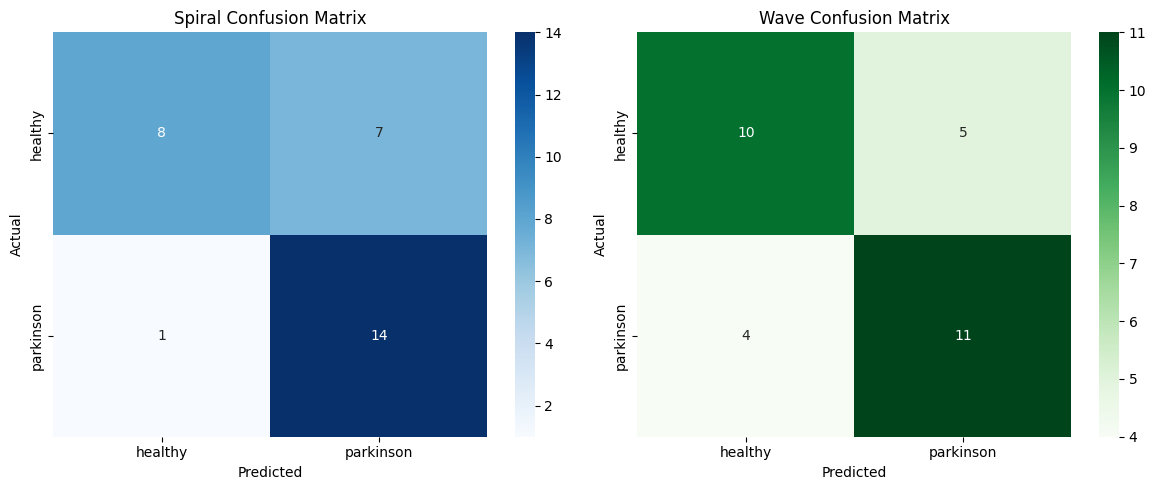

In [5]:
# 1. Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    cm_spiral, annot=True, fmt="d", cmap="Blues",
    xticklabels=["healthy", "parkinson"],
    yticklabels=["healthy", "parkinson"],
    ax=axes[0]
)
axes[0].set_title("Spiral Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(
    cm_wave, annot=True, fmt="d", cmap="Greens",
    xticklabels=["healthy", "parkinson"],
    yticklabels=["healthy", "parkinson"],
    ax=axes[1]
)
axes[1].set_title("Wave Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

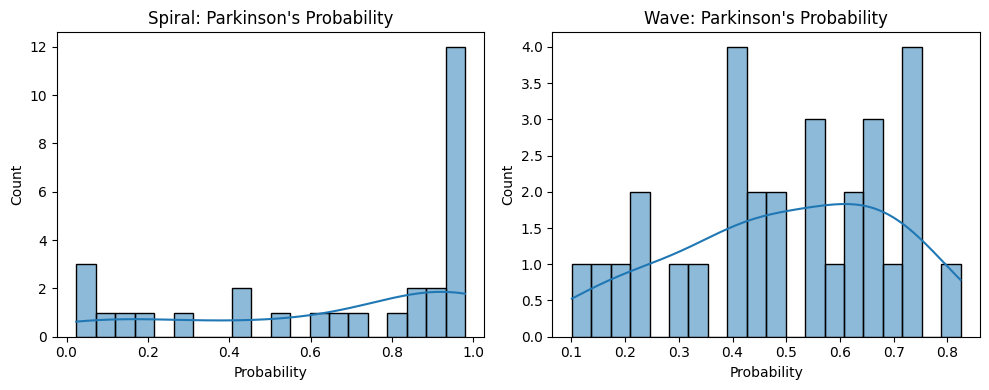

In [6]:
# 2. Probability Distributions
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(df_spiral["parkinson_prob"], bins=20, kde=True)
plt.title("Spiral: Parkinson's Probability")
plt.xlabel("Probability")

plt.subplot(1, 2, 2)
sns.histplot(df_wave["parkinson_prob"], bins=20, kde=True)
plt.title("Wave: Parkinson's Probability")
plt.xlabel("Probability")

plt.tight_layout()
plt.show()

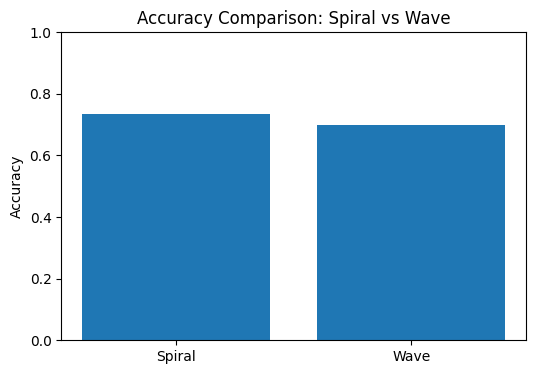

In [7]:
# 3. Accuracy Comparison
plt.figure(figsize=(6, 4))
plt.bar(["Spiral", "Wave"], [acc_spiral, acc_wave])
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Spiral vs Wave")
plt.ylim(0, 1)
plt.show()